In [2]:
% matplotlib inline
% load_ext autoreload
% autoreload 2

In [3]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
from deep_visual_odometry.kitti_utils import KITTIdata
from matplotlib import pyplot as plt
import pickle

In [4]:
basedir = 'dataset'

In [5]:
from deep_visual_odometry.odometry_model import OdomModel

In [44]:
batch_size = 312         # Sequences per batch
num_steps = 16         # Number of sequence steps per batch
rnn_size = 400          # Size of hidden layers in rnn_cell
num_layers = 4           # Number of hidden layers
learning_rate = 0.001   #learning rate

In [40]:
kitti_data = KITTIdata(basedir, 
                       sequences = ['00', '01', '02', '03','04','05','06','07','08'],
                       sequence_len = num_steps,
                       val_frac = 0,
                       test_frac = 0,
                       img_size=(150,50))

completed load sequence 00 data
completed load sequence 01 data
completed load sequence 02 data
completed load sequence 03 data
completed load sequence 04 data
completed load sequence 05 data
completed load sequence 06 data
completed load sequence 07 data
completed load sequence 08 data


In [36]:
kitti_data.normalize()

normalized data


In [73]:
def save_obj(obj,filename):
    with open(filename, 'wb') as filehandler:
        pickle.dump(obj, filehandler)
def load_obj(filename):
    with open(filename, 'rb') as filehandler:
        return pickle.load(filehandler)

In [171]:
model = OdomModel(batch_size = batch_size, 
                  num_steps = num_steps,
                  cell_type = 'GRU',
                  rnn_size = rnn_size,
                  num_layers = num_layers,
                  learning_rate = learning_rate)
loss = model.train(kitti_data, max_count = 3000, save_every_n = 500, sequences = ['00', '02', '05', '08'])

output size (312, 16, 400)
seq_output shape (312, 16, 400)
shape of outputs (312, 16, 3)
shape of targets (312, 16, 3)
step: 25  loss: 62.3579  0.3710 sec/batch
step: 50  loss: 52.8952  0.3990 sec/batch
step: 75  loss: 47.9281  0.3634 sec/batch
step: 100  loss: 46.3846  0.3919 sec/batch
step: 125  loss: 42.2797  0.3725 sec/batch
step: 150  loss: 40.7206  0.3901 sec/batch
step: 175  loss: 40.1415  0.3788 sec/batch
step: 200  loss: 40.0491  0.4032 sec/batch
step: 225  loss: 37.1005  0.3990 sec/batch
step: 250  loss: 36.1908  0.3963 sec/batch
step: 275  loss: 32.5509  0.3958 sec/batch
step: 300  loss: 29.9683  0.3712 sec/batch
step: 325  loss: 28.1746  0.3738 sec/batch
step: 350  loss: 30.6910  0.3700 sec/batch
step: 375  loss: 27.5498  0.3697 sec/batch
step: 400  loss: 26.6000  0.3721 sec/batch
step: 425  loss: 24.8057  0.3812 sec/batch
step: 450  loss: 22.5728  0.3757 sec/batch
step: 475  loss: 23.3858  0.3735 sec/batch
step: 500  loss: 22.3826  0.3760 sec/batch
step: 525  loss: 19.6880

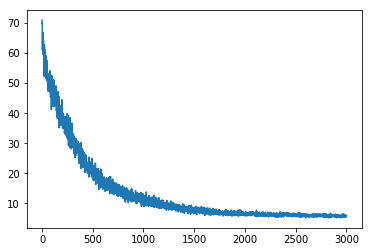

In [173]:
plt.plot(loss)

In [174]:
model = OdomModel(batch_size = batch_size, 
                  num_steps = num_steps,
                  cell_type = 'GRU',
                  rnn_size = rnn_size,
                  num_layers = num_layers,
                  learning_rate = learning_rate,
                  sampling = True)

output size (1, 1, 400)
seq_output shape (1, 1, 400)
shape of outputs (1, 1, 3)
shape of targets (1, 1, 3)


In [234]:
inputs, inter_inputs, targets = kitti_data.get_full_sequence(sequence = '08')
inter_inputs.shape

(4070, 5)

In [235]:
checkpoint = tf.train.latest_checkpoint('checkpoints')
predictions = model.test(checkpoint, inter_inputs, priming_len = inter_inputs.shape[0])
predictions.shape

INFO:tensorflow:Restoring parameters from checkpoints/i3001_l400.ckpt


(4070, 3)

In [ ]:
predictions = predictions*kitti_data.pose_std+kitti_data.pose_mean
targets = targets*kitti_data.pose_std+kitti_data.pose_mean

Text(0,0.5,'y')

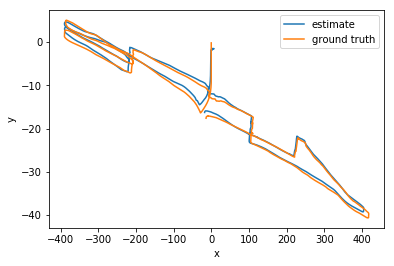

In [239]:
plt.plot(predictions[:,0],predictions[:,1],label = 'estimate')
plt.plot(targets[:,0],targets[:,1],label = 'ground truth')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')